In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tensorflow import keras
import re
from tqdm import tqdm
import math


2025-12-04 10:03:16.934890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764842596.955681     139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764842596.961952     139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1764842602.039789     139 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
ROOT = '/kaggle/input/competition-3/2025-datalab-cup3-reverse-image-caption'
VOCAB = '/dictionary/id2Word.npy'
WORD2ID = '/dictionary/word2Id.npy'
ID2WORD = '/dictionary/id2Word.npy'
TRAIN = '/dataset/text2ImgData.pkl'
TEST = '/dataset/testData.pkl'

In [4]:
train_path = ROOT+TRAIN
vocab_path = ROOT+VOCAB
word2_id_path = ROOT+WORD2ID
id2_word_path = ROOT+ID2WORD

In [5]:
vocab = np.load(vocab_path)
print('there are {} vocabularies in total'.format(len(vocab)))
word2Id_dict = dict(np.load(word2_id_path))
id2word_dict = dict(np.load(id2_word_path))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5429 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [6]:
df_train = pd.read_pickle(train_path)
print(df_train.head(5))
print(df_train.shape)

                                               Captions  \
ID                                                        
6734  [[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...   
6736  [[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...   
6737  [[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...   
6738  [[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...   
6739  [[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...   

                         ImagePath  
ID                                  
6734  ./102flowers/image_06734.jpg  
6736  ./102flowers/image_06736.jpg  
6737  ./102flowers/image_06737.jpg  
6738  ./102flowers/image_06738.jpg  
6739  ./102flowers/image_06739.jpg  
(7370, 2)


In [7]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line
text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [8]:
def id2Sent(id_list):
    words = []
    for idx in id_list:
        idx_str = str(int(idx))   # id 可能是 int 或 numpy.int，需要轉成 str 才能 index dict
        if idx_str in id2word_dict:
            word = id2word_dict[idx_str]
            if word != "<PAD>" and word!="<RARE>":
                words.append(word)
    sentence = " ".join(words)
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence
sample = ['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']
sample_text = id2Sent(sample)
print(sample_text)

the flower shown has yellow anther red pistil and bright red petals


## TEXT ENCODER

In [ ]:
from transformers import CLIPTokenizer, TFCLIPTextModel
MAX_LEN = 77
clip_version="openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(clip_version)
clip_text_encoder =  TFCLIPTextModel.from_pretrained(clip_version)
clip_text_encoder.trainable = False

In [ ]:
def id2clip(ids):
    sentence = id2Sent(ids)
    token_dict = clip_tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="tf"
    )
    
    outputs = clip_text_encoder(
        input_ids=token_dict["input_ids"],
        attention_mask=token_dict["attention_mask"],
        training=False
    )
    seq_emb = outputs.last_hidden_state           
    return seq_emb 
sample = ['9', '1', '82', '5', '11', '70', '20', '31', 
          '3', '29', '20', '2', '5427', '5427', '5427', '5427', 
          '5427', '5427', '5427', '5427']
sample_emb = id2clip(sample)
print(sample_emb.shape)

In [ ]:
save_embeding_path = "/kaggle/working/seq_emb_multi.npy"
max_caption_len = 5
from tqdm import tqdm
def preprocess_captions_all(filenames, save_path, max_len):
    df = pd.read_pickle(filenames)
    captions_list = df["Captions"].values     
    seq_emb_list = []
    for cap_list in tqdm(captions_list):
        emb_list = []
        for i,ids in enumerate(cap_list):
            if i>=max_len:
                break
            emb = id2clip(ids)                
            emb_list.append(emb)
        emb_arr = np.stack(emb_list, axis=0)   
        seq_emb_list.append(emb_arr)
    seq_emb_arr = np.stack(seq_emb_list, axis=0)
    print("saved:", seq_emb_arr.shape)        
    np.save(save_path, seq_emb_arr)

preprocess_captions_all(train_path, save_embeding_path,max_caption_len)


In [ ]:
df_train = pd.read_pickle(train_path)
print(df_train.shape)

In [ ]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNEL = 3
TRAIN_RATIO = 0.8
ARGUMENTATION = 2
BATCH = 8
ARGUMENTATION_RATIO = 0.5

In [ ]:
save_embeding_path = "/kaggle/working/seq_emb_multi.npy"
def training_image_map(seq_emb,image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    if  np.random.rand() < ARGUMENTATION_RATIO:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.05)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.95, 1.05)
        img = tf.image.random_hue(img, 0.02)
    return seq_emb, img
def validation_image_map(seq_emb,image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return seq_emb, img
    
def dataset_generator(filenames, batch_size,train_size, aug_ratio):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    seq_emb_multi = np.load(save_embeding_path)
    seq_emb_multi = np.squeeze(seq_emb_multi,axis=2)
    df['ImagePath'] = df['ImagePath'].str.replace('^\\.', '', regex=True)
    image_paths = ROOT+df['ImagePath'].values
    
    assert seq_emb_multi.shape[0] == image_paths.shape[0]
    N, C, _, _ = seq_emb_multi.shape
    split_idx = int(N * train_size)

    seq_train = seq_emb_multi[:split_idx]         # (N_train, C, 77, 768)
    img_train = image_paths[:split_idx]
    
    seq_val = seq_emb_multi[split_idx:]          # (N_val, C, 77, 768)
    img_val = image_paths[split_idx:]
    
    train_ds = tf.data.Dataset.from_tensor_slices((seq_train,img_train))
    train_ds = train_ds.repeat(int(aug_ratio))

    valid_ds = tf.data.Dataset.from_tensor_slices((seq_val,img_val))
    def training_map(seq_emb_all, image_path):
        num_caps = tf.shape(seq_emb_all)[0]
        idx = tf.random.uniform([], 0, num_caps, dtype=tf.int32)
        seq_emb = seq_emb_all[idx]              
        return training_image_map(seq_emb, image_path)
    
    def validation_map(seq_emb_all, image_path):
        seq_emb = seq_emb_all[0]              
        return validation_image_map(seq_emb, image_path)
   
    train_ds = (
        train_ds.map(training_map,
             num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(len(seq_train), reshuffle_each_iteration=True)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    valid_ds = (
        valid_ds.map(validation_map,
             num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(len(seq_val), reshuffle_each_iteration=True)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    
    return train_ds,valid_ds

In [ ]:
train_ds,valid_ds = dataset_generator(train_path,BATCH,TRAIN_RATIO,ARGUMENTATION)

In [9]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNEL = 3
# 設定一個稍大的尺寸用於隨機裁切 (Zoom effect)
RESIZE_HEIGHT = 156
RESIZE_WIDTH = 156

save_embeding_path = "/kaggle/input/comp3-seq-emb/seq_emb.npy"

# --- 1. 定義基礎讀取圖片函數 ---
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # 轉為 [0, 1]
    return img

# --- 2. 訓練集專用 Mapping (包含 Data Augmentation) ---
def process_train_data(seq_emb, image_path):
    img = load_image(image_path)
    
    # === Data Augmentation 開始 ===
    
    # A. 隨機縮放與裁切 (模擬 Zoom In/Shift)
    # 先放大到 72x72
    img = tf.image.resize(img, size=(RESIZE_HEIGHT, RESIZE_WIDTH))
    # 再隨機裁切回 64x64
    img = tf.image.random_crop(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    
    # B. 隨機左右翻轉 (對花朵資料集非常有效)
    img = tf.image.random_flip_left_right(img)
    
    # C. 隨機亮度與對比度 (增加光影變化的魯棒性)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    
    # D. 確保數值仍在 [0, 1] 範圍內 (因為亮度調整可能使其超出範圍)
    img = tf.clip_by_value(img, 0.0, 1.0)
    
    # === Data Augmentation 結束 ===
    
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return seq_emb, img

# --- 3. 驗證集專用 Mapping (只做 Resize，不增強) ---
def process_val_data(seq_emb, image_path):
    img = load_image(image_path)
    
    # 驗證集不做隨機裁切，直接 Resize 到目標大小
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # 確保數值在 [0, 1] (通常 load_image 已經做了，但保險起見)
    img = tf.clip_by_value(img, 0.0, 1.0)
    
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return seq_emb, img

# --- 4. 修改後的 Dataset Generator ---
def dataset_generator(filenames, batch_size, train_size):
    # load the training data
    df = pd.read_pickle(filenames)
    seq_emb = np.load(save_embeding_path)
    seq_emb = np.squeeze(seq_emb, axis=1) 
    
    # 路徑處理
    df['ImagePath'] = df['ImagePath'].str.replace('^\\.', '', regex=True)
    image_paths = ROOT + df['ImagePath'].values
    
    # 切分資料索引
    N, _, _ = seq_emb.shape
    split_idx = int(N * train_size)
    
    seq_train = seq_emb[:split_idx]        
    img_train = image_paths[:split_idx]
    
    seq_val = seq_emb[split_idx:]          
    img_val = image_paths[split_idx:]
    
    # --- 建立 Training Dataset (使用 process_train_data) ---
    assert seq_train.shape[0] == img_train.shape[0]
    train_data = tf.data.Dataset.from_tensor_slices((seq_train, img_train))
    # 這裡使用 process_train_data
    train_data = train_data.map(process_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_data = train_data.shuffle(len(seq_train)).batch(batch_size, drop_remainder=True)
    train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # --- 建立 Validation Dataset (使用 process_val_data) ---
    assert seq_val.shape[0] == img_val.shape[0]
    val_data = tf.data.Dataset.from_tensor_slices((seq_val, img_val))
    # 這裡使用 process_val_data (不做增強，確保驗證公平性)
    val_data = val_data.map(process_val_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_data = val_data.shuffle(len(seq_val)).batch(batch_size, drop_remainder=True)
    val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # --- 建立 Full Dataset (通常不需要增強，或視需求而定) ---
    # 這裡我預設全量數據不做增強，如果這是用來最終訓練的，可以改用 process_train_data
    dataset = tf.data.Dataset.from_tensor_slices((seq_emb, image_paths))
    dataset = dataset.map(process_val_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(seq_emb)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset, train_data, val_data

In [10]:
BATCH_SIZE = 16
dataset,train_data,valid_data = dataset_generator(train_path, BATCH_SIZE,0.8)

In [ ]:
steps, (seq_emb, image) = next(iter(enumerate(train_ds)))
print(type(image))
print(getattr(image, "shape", None))
print(getattr(image, "dtype", None))
print(type(seq_emb))
print(getattr(seq_emb, "shape", None))
print(getattr(seq_emb, "dtype", None))

## Basie Layers and Function

In [11]:
class PaddedConv2D(keras.layers.Layer):
    def __init__(self, channels, kernel_size, padding=0, stride=1):
        super().__init__()
        self.padding2d = keras.layers.ZeroPadding2D((padding, padding))
        self.conv2d = keras.layers.Conv2D(
            channels, kernel_size, strides=(stride, stride)
        )

    def call(self, x):
        x = self.padding2d(x)
        return self.conv2d(x)


class GEGLU(keras.layers.Layer):
    def __init__(self, dim_out):
        super().__init__()
        self.proj = keras.layers.Dense(dim_out * 2)
        self.dim_out = dim_out

    def call(self, x):
        xp = self.proj(x)
        x, gate = xp[..., : self.dim_out], xp[..., self.dim_out :]
        return x * gelu(gate)


def gelu(x):
    tanh_res = keras.activations.tanh(x * 0.7978845608 * (1 + 0.044715 * (x**2)))
    return 0.5 * x * (1 + tanh_res)


def quick_gelu(x):
    return x * tf.sigmoid(x * 1.702)


def apply_seq(x, layers):
    for l in layers:
        x = l(x)
    return x

def td_dot(a, b):
    aa = tf.reshape(a, (-1, a.shape[2], a.shape[3]))
    bb = tf.reshape(b, (-1, b.shape[2], b.shape[3]))
    cc = keras.backend.batch_dot(aa, bb)
    return tf.reshape(cc, (-1, a.shape[1], cc.shape[1], cc.shape[2]))


## VAE

In [12]:
class ResnetBlock(keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.norm1 = keras.layers.GroupNormalization(epsilon=1e-5)
        self.conv1 = PaddedConv2D(out_channels, 3, padding=1)
        self.norm2 = keras.layers.GroupNormalization(epsilon=1e-5)
        self.conv2 = PaddedConv2D(out_channels, 3, padding=1)
        self.nin_shortcut = (
            PaddedConv2D(out_channels, 1)
            if in_channels != out_channels
            else lambda x: x
        )

    def call(self, x):
        h = self.norm1(x)
        h = keras.activations.swish(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = keras.activations.swish(h)
        h = self.conv2(h)

        return self.nin_shortcut(x) + h


class AttentionBlock(keras.layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.norm = keras.layers.GroupNormalization(epsilon=1e-5)
        self.q = PaddedConv2D(channels, 1)
        self.k = PaddedConv2D(channels, 1)
        self.v = PaddedConv2D(channels, 1)
        self.proj_out = PaddedConv2D(channels, 1)

    def call(self, x):
        # x: [B, H, W, C]
        h = self.norm(x)
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)

        b = tf.shape(q)[0]
        h_ = tf.shape(q)[1]
        w_ = tf.shape(q)[2]
        c = tf.shape(q)[3]
        hw = h_ * w_

        def reshape_hw(t):
            return tf.reshape(t, [b, hw, c])

        q_flat = reshape_hw(q)
        k_flat = reshape_hw(k)
        v_flat = reshape_hw(v)

        attn_logits = tf.matmul(q_flat, k_flat, transpose_b=True)
        attn_logits = attn_logits * tf.cast(c, tf.float32) ** -0.5
        attn = tf.nn.softmax(attn_logits, axis=-1)

        out_flat = tf.matmul(attn, v_flat)
        out = tf.reshape(out_flat, [b, h_, w_, c])
        out = self.proj_out(out)
        return x + out


In [13]:
class Encoder(keras.Model):
    def __init__(self, latent_channels=4):
        super().__init__()
        self.down = keras.Sequential(
            [
                # 64x64 -> 64x64
                PaddedConv2D(128, 3, padding=1),
                ResnetBlock(128, 128),
                ResnetBlock(128, 128),

                # 64 -> 32
                PaddedConv2D(128, 3, padding=(0,1), stride=2),

                ResnetBlock(128, 256),
                ResnetBlock(256, 256),

                # 32 -> 16
                PaddedConv2D(256, 3, padding=(0,1), stride=2),

                ResnetBlock(256, 512),
                ResnetBlock(512, 512),

                # 16 -> 8
                PaddedConv2D(512, 3, padding=(0,1), stride=2),

                ResnetBlock(512, 512),
                ResnetBlock(512, 512),

                # mid block with attention at 8x8
                ResnetBlock(512, 512),
                AttentionBlock(512),
                ResnetBlock(512, 512),

                keras.layers.GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                
            ]
        )
        # 輸出 2 * latent_channels，前半是 mu，後半是 logvar
        self.conv_out1 = PaddedConv2D(latent_channels * 2, 3, padding=1)
        self.conv_out2 = PaddedConv2D(latent_channels * 2, 1)

        self.latent_channels = latent_channels

    def call(self, x, training=False):
        h = self.down(x, training=training)
        h = self.conv_out1(h)
        h = self.conv_out2(h)  # [B, 8, 8, 2C]
        mu, logvar = tf.split(h, num_or_size_splits=2, axis=-1)
        return mu, logvar


In [14]:
class Decoder(keras.Model):
    def __init__(self, latent_channels=4):
        super().__init__()

        self.latent_channels = latent_channels

        self.in_conv = keras.Sequential([
            PaddedConv2D(4, 1),
            PaddedConv2D(512, 3, padding=1),
        ])

        self.mid = keras.Sequential(
            [
                ResnetBlock(512, 512),
                AttentionBlock(512),
                ResnetBlock(512, 512),
                ResnetBlock(512, 512),
                ResnetBlock(512, 512),
                ResnetBlock(512, 512),
            ]
        )

        self.up = keras.Sequential(
            [
                # 8 -> 16
                keras.layers.UpSampling2D(size=(2, 2)),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512, 512),
                ResnetBlock(512, 512),
                ResnetBlock(512, 512),

                # 16 -> 32
                keras.layers.UpSampling2D(size=(2, 2)),
                PaddedConv2D(512, 3, padding=1),
                ResnetBlock(512, 256),
                ResnetBlock(256, 256),
                ResnetBlock(256, 256),

                # 32 -> 64
                keras.layers.UpSampling2D(size=(2, 2)),
                PaddedConv2D(256, 3, padding=1),
                ResnetBlock(256, 128),
                ResnetBlock(128, 128),
                ResnetBlock(128, 128),

                keras.layers.GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(3, 3, padding=1),
            ]
        )
        

    def call(self, z, training=False):
        # z: [B, 8, 8, latent_channels]
        # 先升到 512 channels
        h = self.in_conv(z)
        h = self.mid(h, training=training)
        x_recon = self.up(h, training=training)  # [B, 64, 64, 3]
        return x_recon


In [15]:

decoder_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/decoder.h5",
            file_hash="6d3c5ba91d5cc2b134da881aaa157b2d2adc648e5625560e3ed199561d0e39d5",
        )

encoder_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/divamgupta/stable-diffusion-tensorflow/resolve/main/encoder_newW.h5",
    file_hash="56a2578423c640746c5e90c0a789b9b11481f47497f817e65b44a1a5538af754",
)


198152112/198152112 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
136801296/136801296 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
class AutoencoderKL(keras.Model):
    def __init__(self, encoder, decoder, latent_channels=4, scaling_factor=0.18215):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_channels = latent_channels
        self.scaling_factor = scaling_factor
        
    def encode(self, x, training=False):
        mu, logvar = self.encoder(x, training=training)
        return mu, logvar
    
    def reparameterize(self, mu, logvar, training=False):
        if training:
            std = tf.exp(0.5 * logvar)
            eps = tf.random.normal(tf.shape(std))
            z = mu + eps * std
            z = z
        else:
            z = mu
        return z
    
    def decode(self, z, training=False):
        x_recon = self.decoder(z, training=training)
        return x_recon
    
    def call(self, x, training=False):
        mu, logvar = self.encode(x, training=training)
        z = self.reparameterize(mu, logvar, training=training)
        x_recon = self.decode(z, training=training)
        return x_recon, mu, logvar, z
    
    @staticmethod
    def kl_loss(mu, logvar):
        """KL 散度損失"""
        kl = 0.5 * tf.reduce_mean(
            tf.reduce_sum(
                tf.square(mu) + tf.exp(logvar) - logvar - 1.0,
                axis=[1, 2, 3],
            )
        )
        return kl
    
    @staticmethod
    def reconstruction_loss(x, x_recon, l1_weight=1.0, l2_weight=0.0):
        """
        增強型重建損失
        - L1 損失：像素級精確度
        - L2 損失：可選
        - 色彩統計損失：保持色彩分佈和飽和度
        """
        l1 = tf.reduce_mean(tf.abs(x - x_recon))
        l2 = tf.reduce_mean(tf.square(x - x_recon))
        
        # x_flat = tf.reshape(x, [-1, 3])
        # x_recon_flat = tf.reshape(x_recon, [-1, 3])
        
        # x_mean = tf.reduce_mean(x_flat, axis=0)
        # x_recon_mean = tf.reduce_mean(x_recon_flat, axis=0)
        # x_std = tf.math.reduce_std(x_flat, axis=0)
        # x_recon_std = tf.math.reduce_std(x_recon_flat, axis=0)
        
        # color_stat_loss = (
        #     tf.reduce_mean(tf.abs(x_mean - x_recon_mean)) +
        #     tf.reduce_mean(tf.abs(x_std - x_recon_std))
        # )
        
        # x_intensity = tf.reduce_mean(x, axis=-1, keepdims=True)
        # x_recon_intensity = tf.reduce_mean(x_recon, axis=-1, keepdims=True)
        # intensity_loss = tf.reduce_mean(tf.abs(x_intensity - x_recon_intensity))
        
        return (
            l1_weight * l1 + 
            l2_weight * l2 
            # 0.2 * color_stat_loss + 
            # 0.1 * intensity_loss
        )

In [17]:
class SDPatchGANDiscriminator(keras.Model):
    """
    Stable Diffusion / VQGAN 使用的 NLayerDiscriminator 的 Keras 版實作。
    等價於 taming.modules.discriminator.model.NLayerDiscriminator
    （PatchGAN 判別器）。
    """

    def __init__(self,
                 input_channels=3,
                 base_filters=64,   # ndf
                 n_layers=3,        # 卷積層數（不含最後輸出層）
                 use_actnorm=False  # SD 一般是 False => BatchNorm
                 ):
        super().__init__()
        self.input_channels = input_channels
        self.base_filters = base_filters
        self.n_layers = n_layers
        self.use_actnorm = use_actnorm

        self.model = self._build_model()

    def _norm_layer(self):
        # SD 預設是 BatchNorm2d；ActNorm 這裡先不實作，直接用 BatchNorm 就好
        # 如果你真的想做 ActNorm，可以另外自定義一個 Layer。
        return layers.BatchNormalization

    def _build_model(self):
        kw = 4
        pad = "same"
        Norm = self._norm_layer()

        seq = []

        # --- 第一層：Conv + LeakyReLU（沒有 normalization） ---
        nf_mult = 1
        seq.append(layers.Conv2D(
            self.base_filters * nf_mult,
            kernel_size=kw,
            strides=2,
            padding=pad,
            use_bias=True      # 原始 PyTorch 版第一層有 bias
        ))
        seq.append(layers.LeakyReLU(0.2))

        # --- 中間層：逐層加深，stride=2，下採樣 ---
        nf_mult_prev = nf_mult
        for n in range(1, self.n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)  # 最多乘到 8

            seq.append(layers.Conv2D(
                self.base_filters * nf_mult,
                kernel_size=kw,
                strides=2,
                padding=pad,
                use_bias=False   # 後面接 norm，原始實作會關掉 bias
            ))
            seq.append(Norm())
            seq.append(layers.LeakyReLU(0.2))

        # --- 倒數第二層：stride=1，維持空間尺寸 ---
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** self.n_layers, 8)

        seq.append(layers.Conv2D(
            self.base_filters * nf_mult,
            kernel_size=kw,
            strides=1,
            padding=pad,
            use_bias=False
        ))
        seq.append(Norm())
        seq.append(layers.LeakyReLU(0.2))

        # --- 最後輸出 1 channel 的 patch score map ---
        seq.append(layers.Conv2D(
            1,
            kernel_size=kw,
            strides=1,
            padding=pad,
            use_bias=True
        ))

        return keras.Sequential(seq, name="sd_patchgan_discriminator")

    def call(self, x, training=False):
        return self.model(x, training=training)

class LPIPSLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 使用 VGG19 的特定層來計算感知損失 (Perceptual Loss)
        vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
        # 鎖定參數，不訓練 VGG
        vgg.trainable = False
        
        # 選擇多個特徵層，這比只選一層更穩定
        outputs = [
            vgg.get_layer('block1_conv2').output,
            vgg.get_layer('block2_conv2').output,
            vgg.get_layer('block3_conv4').output,
            vgg.get_layer('block4_conv4').output,
            vgg.get_layer('block5_conv4').output
        ]
        self.vgg_model = keras.Model(vgg.input, outputs)
        self.mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
        self.std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

    def preprocess(self, x):
        # 假設輸入 x 在 [-1, 1] 之間
        # VGG 需要輸入在 [0, 1] 區間，然後做 ImageNet Normalize
        x = (x + 1.0) * 0.5  # [-1, 1] -> [0, 1]
        
        # (Batch, H, W, 3) - (3,) -> Broadcasting
        x = (x - self.mean) / self.std
        return x

    def call(self, real, fake):
        # 確保形狀正確
        real_features = self.vgg_model(self.preprocess(real))
        fake_features = self.vgg_model(self.preprocess(fake))
        
        loss = 0.0
        # 加總所有層的 L1 距離 (或 L2)
        for r, f in zip(real_features, fake_features):
            loss += tf.reduce_mean(tf.abs(r - f))
            
        return loss

class VAETrainer(keras.Model):
    def __init__(self, vae, discriminator, 
                 disc_start=50001,  # <--- 關鍵：前 50000 步不訓練 GAN
                 kl_weight=1e-6, 
                 perc_weight=0.1,
                 disc_weight=0.5):  # CompVis 原始設定通常是 0.5
        super().__init__()
        self.vae = vae
        self.discriminator = discriminator
        self.lpips = LPIPSLayer()
        
        self.disc_start = disc_start
        self.kl_weight = kl_weight
        self.perc_weight = perc_weight
        self.disc_weight = disc_weight
        
        # 追蹤步數
        self.global_step = tf.Variable(0, trainable=False, dtype=tf.int64)

        # Metrics
        self.loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.perc_loss_tracker = keras.metrics.Mean(name="perc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")

    def compile(self, vae_optimizer, disc_optimizer):
        super().compile()
        self.vae_optimizer = vae_optimizer
        self.disc_optimizer = disc_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
            self.perc_loss_tracker,
            self.gen_loss_tracker,
            self.disc_loss_tracker,
        ]
    @tf.function
    def train_step(self, data):
        # 處理數據輸入，如果是 tuple (x, y) 取 x
        if isinstance(data, tuple):
            data = data[0]
        
        real_imgs = data # 假設已經是 [-1, 1]

        with tf.GradientTape() as tape, tf.GradientTape() as disc_tape:
            # 1. VAE Forward
            # 這裡假設 AutoencoderKL 回傳 (x_recon, mu, logvar, z)
            recon_imgs, mu, logvar, _ = self.vae(real_imgs, training=True)

            # --- Reconstruction Loss (L1) ---
            recon_loss = tf.reduce_mean(tf.abs(real_imgs - recon_imgs))
            
            # --- Perceptual Loss (LPIPS) ---
            p_loss = self.lpips(real_imgs, recon_imgs)
            
            # --- KL Loss ---
            # 0.5 * sum(mu^2 + exp(logvar) - 1 - logvar)
            kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=[1, 2, 3])
            kl_loss = tf.reduce_mean(kl_loss)

            # --- Generator Loss (GAN) ---
            # 判斷是否達到開啟 GAN 的步數
            start_gan = self.global_step >= self.disc_start
            
            if start_gan:
                # 這裡計算 generator 想要騙過 discriminator 的 loss
                logits_fake = self.discriminator(recon_imgs, training=True)
                g_loss = -tf.reduce_mean(logits_fake)
                
                # 根據 CompVis 實作，這裡通常會有一個 adaptive weight (lambda)，
                # 為了簡化，我們先用固定的 disc_weight，若要進階需計算最後一層梯度比值。
                disc_factor = self.disc_weight 
            else:
                g_loss = 0.0
                disc_factor = 0.0

            # VAE Total Loss
            vae_loss = (
                recon_loss + 
                (self.perc_weight * p_loss) + 
                (self.kl_weight * kl_loss) + 
                (disc_factor * g_loss)
            )

            # --- Discriminator Loss ---
            if start_gan:
                logits_real = self.discriminator(real_imgs, training=True)
                # 這裡一定要用 detached (stop_gradient) 的 recon_imgs，否則梯度會流回 VAE
                logits_fake_detached = self.discriminator(tf.stop_gradient(recon_imgs), training=True)
                
                # Hinge Loss
                d_loss_real = tf.reduce_mean(tf.nn.relu(1.0 - logits_real))
                d_loss_fake = tf.reduce_mean(tf.nn.relu(1.0 + logits_fake_detached))
                disc_loss = 0.5 * (d_loss_real + d_loss_fake)
            else:
                disc_loss = 0.0

        # 2. Update VAE
        vae_grads = tape.gradient(vae_loss, self.vae.trainable_weights)
        # 加上 Gradient Clipping 防止梯度爆炸
        vae_grads = [tf.clip_by_norm(g, 1.0) for g in vae_grads] 
        self.vae_optimizer.apply_gradients(zip(vae_grads, self.vae.trainable_weights))

        # 3. Update Discriminator (Only if started)
        if start_gan:
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
            disc_grads = [tf.clip_by_norm(g, 1.0) for g in disc_grads]
            self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        # 更新步數
        self.global_step.assign_add(1)

        # Update metrics
        self.loss_tracker.update_state(vae_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.perc_loss_tracker.update_state(p_loss)
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        return {
            "loss": self.loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "perc_loss": self.perc_loss_tracker.result(),
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "step": self.global_step
        }


In [18]:

decoder = Decoder()
latent = keras.layers.Input((16,16,4))
decoder = keras.models.Model(latent, decoder(latent))
decoder.load_weights(decoder_weights_fpath)

encoder = Encoder()
inp_img = keras.layers.Input((128,128,3))
encoder = keras.models.Model(inp_img,encoder(inp_img))
encoder.load_weights(encoder_weights_fpath)


In [19]:
h_disc_start= 0
h_kl_weight=1e-6, 
h_perc_weight=0.1,
h_disc_weight=0.05
vae = AutoencoderKL(encoder,decoder,latent_channels=4, scaling_factor=0.18215)
discriminator =SDPatchGANDiscriminator(
    input_channels=3,
    base_filters=64,
    n_layers=3  # SD, VQGAN 常用設定
)
trainer = VAETrainer(vae, discriminator,disc_start=h_disc_start,kl_weight=h_kl_weight,perc_weight=h_perc_weight,disc_weight=h_disc_weight)

base_lr = 4.5e-6
lr = base_lr * BATCH_SIZE
vae_opt = keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)
disc_opt = keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)

trainer.compile(
    vae_optimizer=vae_opt,
    disc_optimizer=disc_opt
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [20]:
weight_path = {}
weight_path['encoder'] = '/kaggle/working/encoder.weights.h5'
weight_path['decoder'] = '/kaggle/working/decoder.weights.h5'


In [21]:
def show_vae_reconstructions(autoencoder, dataset, num_images=8):
    for _ ,img_batch in dataset.take(1):
        imgs = img_batch[:num_images]          # [N, 64, 64, 3], in [0,1]
        x_in = imgs * 2.0 - 1.0
        x_recon, mu, logvar, z = autoencoder(x_in, training=False)
        x_recon = (x_recon + 1.0) / 2.0
        imgs_vis = tf.clip_by_value(imgs, 0.0, 1.0)
        recon_vis = tf.clip_by_value(x_recon, 0.0, 1.0)
        plt.figure(figsize=(2 * num_images, 4))
        for i in range(num_images):
            # 上排：原圖
            plt.subplot(2, num_images, i + 1)
            plt.imshow(imgs_vis[i].numpy())
            plt.axis("off")
            if i == 0:
                plt.ylabel("Original", fontsize=12)

            # 下排：重建圖
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(recon_vis[i].numpy())
            plt.axis("off")
            if i == 0:
                plt.ylabel("Reconstructed", fontsize=12)

        plt.tight_layout()
        plt.show()
        break  # 只看第一個 batch 就好

In [ ]:
def calculate_latent_scale(vae_encoder, dataset):
    all_latents = []
    for _, img_batch in tqdm(dataset):
        # 1. 獲取圖片 (假設 dataset 輸出是 (images, texts) 或單純 images)
        mean, log_var = vae_encoder(img_batch)
        
        # 3. Reparameterization Trick (採樣)
        # z = mean + epsilon * exp(0.5 * log_var)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + epsilon * tf.exp(0.5 * log_var)
        all_latents.append(z.numpy())

    all_latents = np.concatenate(all_latents, axis=0) # Shape: [Total_N, 8, 8, 4]
    mean = np.mean(all_latents)
    std = np.std(all_latents)
    print("mean:",mean," std:",std)

In [ ]:
Epochs = 50
start_epoch = 0
for epoch in range(start_epoch,Epochs):
    for metric in trainer.metrics:
        metric.reset_state()
    pbar = tqdm(dataset, desc=f"Epoch {epoch+1}/{Epochs}")
    
    for seq_emb_batch, img_batch in pbar:
        img_in = img_batch * 2.0 - 1.0 
        logs = trainer.train_step(img_in)
        
        # # (選用) 在進度條上即時顯示當前 Loss，看起來比較爽
        # pbar.set_postfix({
        #     "rec": f"{logs['recon_loss']:.3f}", 
        #     "gan": f"{logs['gen_loss']:.3f}",
        #     "disc": f"{logs['disc_loss']:.3f}"
        # })
    print(
        f"Epoch {epoch+1}: "
        f"perc={logs['perc_loss']:.4f}, "
        f"recon={logs['recon_loss']:.4f}, "
        f"kl={logs['kl_loss']:.4f}",
        f"gen={logs['gen_loss']:.4f}",
        f"disc_loss={logs['disc_loss']:.4f}"
    )
    if(epoch%2 == 0): 
        show_vae_reconstructions(vae, valid_data, num_images=10)
    


I0000 00:00:1764842715.115404     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


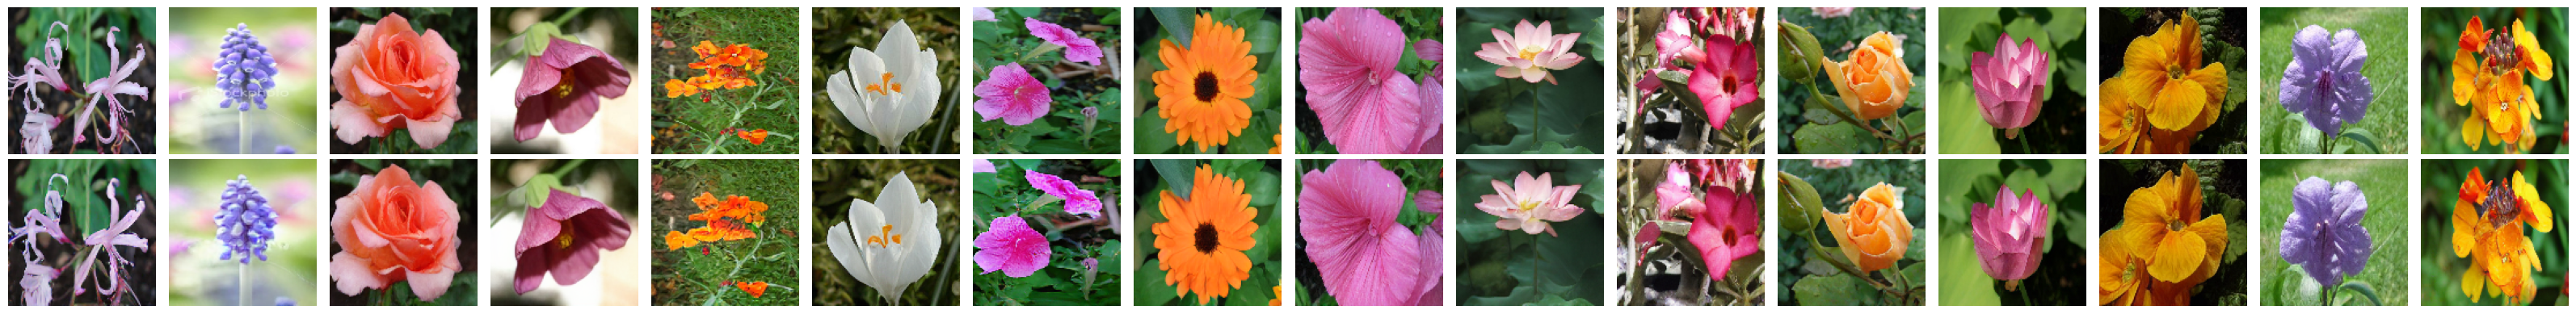

In [22]:
show_vae_reconstructions(vae, dataset, num_images=BATCH_SIZE)

In [23]:
vae.encoder.save_weights(weight_path['encoder'])
vae.decoder.save_weights(weight_path['decoder'])

In [ ]:
def calculate_latent_scale(vae_encoder, dataset):
    all_latents =[]
    for _, img_batch in tqdm(dataset):
        
        mean, log_var = vae_encoder(img_batch)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + epsilon * tf.exp(0.5 * log_var)
        all_latents.append(z.numpy())

    all_latents = np.concatenate(all_latents, axis=0) # Shape: [Total_N, 8, 8, 4]
    
    # 5. 計算整體的標準差 (Standard Deviation)
    mean = np.mean(all_latents)
    std = np.std(all_latents)
    return mean,std

In [ ]:
def interpolate_and_show(autoencoder, image1, image2,
                         num_steps=8,
                         use_sampling=False):
    """
    在 VAE latent space 將兩張圖片做線性內插，並 decode 回來畫出結果。

    Args:
        autoencoder: 你的 VAE，自帶 encoder / decoder
        image1, image2: 單張圖片，shape 可以是 [H, W, C] 或 [1, H, W, C]，值在 [0,1]
        num_steps: 內插幾個點（含兩端），例如 8 → t=0,0.14,...,1
        use_sampling: 
            - False: 用 mean 當 latent，比較穩定
            - True: 依照 mean + std * eps 取樣一個 z1, z2 再內插
    """

    # ------- 確保有 batch 維度 -------
    if image1.ndim == 3:
        image1 = image1[None, ...]
    if image2.ndim == 3:
        image2 = image2[None, ...]

    # ------- 正規化到 [-1, 1] -------
    x1_in = image1 * 2.0 - 1.0
    x2_in = image2 * 2.0 - 1.0

    # ------- encode 拿 latent 分佈 -------
    mean1, logvar1 = autoencoder.encoder(x1_in)
    mean2, logvar2 = autoencoder.encoder(x2_in)

    if use_sampling:
        # 真的依照 Gaussian 分佈各 sample 一個 latent
        std1 = tf.exp(0.5 * logvar1)
        std2 = tf.exp(0.5 * logvar2)
        eps1 = tf.random.normal(tf.shape(mean1))
        eps2 = tf.random.normal(tf.shape(mean2))
        z1 = mean1 + std1 * eps1
        z2 = mean2 + std2 * eps2
    else:
        # 比較常見的做法：直接用 mean 當 latent representation
        z1 = mean1
        z2 = mean2

    # 拿掉 batch 維度方便運算（但 decode 前會加回去）
    z1 = z1[0]
    z2 = z2[0]

    # ------- 做線性內插 -------
    # t 從 0 到 1，一共 num_steps 個點
    ts = tf.linspace(0.0, 1.0, num_steps)

    decoded_imgs = []

    for t in ts:
        t = tf.cast(t, tf.float32)
        z_t = (1.0 - t) * z1 + t * z2          # 線性內插 latent
        z_t = z_t[None, ...]                  # 加回 batch 維度

        # decode 回圖片
        x_hat = autoencoder.decoder(z_t)      # 如果你是 autoencoder.decode，這裡改成 autoencoder.decode(z_t)

        # 如果 decoder 輸出是 [-1,1]，轉回 [0,1] 看圖會比較直覺
        x_hat = (x_hat + 1.0) / 2.0
        x_hat = tf.clip_by_value(x_hat, 0.0, 1.0)

        decoded_imgs.append(x_hat[0].numpy())

    decoded_imgs = np.stack(decoded_imgs, axis=0)  # [num_steps, H, W, C]

    # ------- 畫出 interpolation 結果 -------
    plt.figure(figsize=(2 * num_steps, 3))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(decoded_imgs[i])
        plt.axis("off")
        plt.title(f"{ts[i].numpy():.2f}")
    plt.suptitle("Latent space interpolation")
    plt.show()

    return decoded_imgs  # 如果你之後想存起來用

In [ ]:
mean, scale_factor = calculate_latent_scale(vae.encoder,dataset)

In [ ]:
print(mean,scale_factor)

## UNET

In [24]:
class ResBlock(keras.layers.Layer):
    def __init__(self, channels, out_channels):
        super().__init__()
        self.in_layers = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.activations.swish,
            PaddedConv2D(out_channels, 3, padding=1),
        ]
        self.emb_layers = [
            keras.activations.swish,
            keras.layers.Dense(out_channels),
        ]
        self.out_layers = [
            keras.layers.GroupNormalization(epsilon=1e-5),
            keras.activations.swish,
            PaddedConv2D(out_channels, 3, padding=1),
        ]
        self.skip_connection = (
            PaddedConv2D(out_channels, 1) if channels != out_channels else lambda x: x
        )

    def call(self, inputs):
        x, emb = inputs
        h = apply_seq(x, self.in_layers)
        emb_out = apply_seq(emb, self.emb_layers)
        h = h + emb_out[:, None, None]
        h = apply_seq(h, self.out_layers)
        ret = self.skip_connection(x) + h
        return ret


class CrossAttention(keras.layers.Layer):
    def __init__(self, n_heads, d_head):
        super().__init__()
        self.to_q = keras.layers.Dense(n_heads * d_head, use_bias=False)
        self.to_k = keras.layers.Dense(n_heads * d_head, use_bias=False)
        self.to_v = keras.layers.Dense(n_heads * d_head, use_bias=False)
        self.scale = d_head**-0.5
        self.num_heads = n_heads
        self.head_size = d_head
        self.to_out = [keras.layers.Dense(n_heads * d_head)]

    def call(self, inputs):
        assert type(inputs) is list
        if len(inputs) == 1:
            inputs = inputs + [None]
        x, context = inputs
        context = x if context is None else context
        q, k, v = self.to_q(x), self.to_k(context), self.to_v(context)
        assert len(x.shape) == 3
        q = tf.reshape(q, (-1, x.shape[1], self.num_heads, self.head_size))
        k = tf.reshape(k, (-1, context.shape[1], self.num_heads, self.head_size))
        v = tf.reshape(v, (-1, context.shape[1], self.num_heads, self.head_size))

        q = keras.layers.Permute((2, 1, 3))(q)  # (bs, num_heads, time, head_size)
        k = keras.layers.Permute((2, 3, 1))(k)  # (bs, num_heads, head_size, time)
        v = keras.layers.Permute((2, 1, 3))(v)  # (bs, num_heads, time, head_size)

        score = td_dot(q, k) * self.scale
        weights = keras.activations.softmax(score)  # (bs, num_heads, time, time)
        attention = td_dot(weights, v)
        attention = keras.layers.Permute((2, 1, 3))(
            attention
        )  # (bs, time, num_heads, head_size)
        h_ = tf.reshape(attention, (-1, x.shape[1], self.num_heads * self.head_size))
        return apply_seq(h_, self.to_out)


class BasicTransformerBlock(keras.layers.Layer):
    def __init__(self, dim, n_heads, d_head):
        super().__init__()
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn1 = CrossAttention(n_heads, d_head)

        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn2 = CrossAttention(n_heads, d_head)

        self.norm3 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.geglu = GEGLU(dim * 4)
        self.dense = keras.layers.Dense(dim)

    def call(self, inputs):
        x, context = inputs
        x = self.attn1([self.norm1(x)]) + x
        x = self.attn2([self.norm2(x), context]) + x
        return self.dense(self.geglu(self.norm3(x))) + x


class SpatialTransformer(keras.layers.Layer):
    def __init__(self, channels, n_heads, d_head):
        super().__init__()
        self.norm = keras.layers.GroupNormalization(epsilon=1e-5)
        assert channels == n_heads * d_head
        self.proj_in = PaddedConv2D(n_heads * d_head, 1)
        self.transformer_blocks = [BasicTransformerBlock(channels, n_heads, d_head)]
        self.proj_out = PaddedConv2D(channels, 1)

    def call(self, inputs):
        x, context = inputs
        b, h, w, c = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = tf.reshape(x, (-1, h * w, c))
        for block in self.transformer_blocks:
            x = block([x, context])
        x = tf.reshape(x, (-1, h, w, c))
        return self.proj_out(x) + x_in


class Downsample(keras.layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.op = PaddedConv2D(channels, 3, stride=2, padding=1)

    def call(self, x):
        return self.op(x)


class Upsample(keras.layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.ups = keras.layers.UpSampling2D(size=(2, 2))
        self.conv = PaddedConv2D(channels, 3, padding=1)

    def call(self, x):
        x = self.ups(x)
        return self.conv(x)



class UNetModelSmall(keras.models.Model):
    """
    縮小版 UNet：
      - input:  z_t,  shape [B, 8, 8, 4]
      - t_emb:  time embedding [B, 256]
      - context: text embedding [B, 77, 768]
      - output: epsilon_pred [B, 8, 8, 4]
    """
    def __init__(self):
        super().__init__()

        # 時間 embedding MLP
        self.time_mlp = [
            layers.Dense(512),
            layers.Activation("swish"),
            layers.Dense(512),
        ]

        # ================= Encoder =================
        # Input: [16, 16, 4]
        self.input_blocks = [
            # --- Level 0: 16x16 (Channel: 128) ---
            # Enc 0: Input Conv
            [PaddedConv2D(128, kernel_size=3, padding=1)],

            # Enc 1: [16, 16, 128]
            [ResBlock(128, 128), SpatialTransformer(128, 8, 16)], # Heads=4, Dim=16

            # Enc 2: [16, 16, 128]
            [ResBlock(128, 128), SpatialTransformer(128, 8, 16)],

            # Enc 3: Downsample 16x16 -> 8x8
            [Downsample(128)],

            # --- Level 1: 8x8 (Channel: 256) ---
            # Enc 4: [8, 8, 128] -> [8, 8, 256]
            [ResBlock(128, 256), SpatialTransformer(256, 8, 32)],

            # Enc 5: [8, 8, 256]
            [ResBlock(256, 256), SpatialTransformer(256, 8, 32)],

            # Enc 6: Downsample 8x8 -> 4x4
            [Downsample(256)],

            # --- Level 2: 4x4 (Channel: 512) ---
            # Enc 7: [4, 4, 256] -> [4, 4, 512]
            [ResBlock(256, 512), SpatialTransformer(512, 8, 64)],

            # Enc 8: [4, 4, 512]
            [ResBlock(512, 512), SpatialTransformer(512, 8, 64)],

            # Enc 9: Downsample 4x4 -> 2x2
            [Downsample(512)],

            # --- Level 3: 2x2 (Channel: 512) Bottleneck ---
            # Enc 10: [2, 2, 512]
            [ResBlock(512, 512)],

            # Enc 11: [2, 2, 512]
            [ResBlock(512, 512)],
        ]

        # ================= Middle (2x2, 512 ch) =================
        self.middle_block = [
            ResBlock(512, 512),
            SpatialTransformer(512, 8, 64),
            ResBlock(512, 512),
        ]

        # ================= Decoder =================
        # saved_inputs stack 順序對應 Encoder 0~11
        
        self.output_blocks = [
            # --- Level 3: 2x2 (Skip Enc 11, 10, 9) ---
            # Dec 0 (Skip Enc 11): (512 + 512) -> 512
            [ResBlock(1024, 512)],

            # Dec 1 (Skip Enc 10): (512 + 512) -> 512
            [ResBlock(1024, 512)],

            # Dec 2 (Skip Enc 9): (512 + 512) -> 512 -> Up to 4x4
            [ResBlock(1024, 512), Upsample(512)],

            # --- Level 2: 4x4 (Skip Enc 8, 7, 6) ---
            # Dec 3 (Skip Enc 8): (512 + 512) -> 512
            [ResBlock(1024, 512), SpatialTransformer(512, 8, 64)],

            # Dec 4 (Skip Enc 7): (512 + 512) -> 512 -> Reduce to 256
            [ResBlock(1024, 512), SpatialTransformer(512, 8, 64)],

            # Dec 5 (Skip Enc 6): (256 + 256) -> 256 -> Up to 8x8
            [ResBlock(768, 512),
             SpatialTransformer(512, 8, 64),
             Upsample(512)],

            # --- Level 1: 8x8 (Skip Enc 5, 4, 3) ---
            # Dec 6 (Skip Enc 5): (256 + 256) -> 256
            [ResBlock(768, 256), SpatialTransformer(256, 8, 32)],

            # Dec 7 (Skip Enc 4): (256 + 256) -> 256 -> Reduce to 128
            [ResBlock(512, 256), SpatialTransformer(256, 8, 32)],

            # Dec 8 (Skip Enc 3): (128 + 128) -> 128 -> Up to 16x16
            [ResBlock(384, 256),
             SpatialTransformer(256, 8, 32),
             Upsample(256)],

            # --- Level 0: 16x16 (Skip Enc 2, 1, 0) ---
            # Dec 9 (Skip Enc 2): (128 + 128) -> 128
            [ResBlock(384, 128), SpatialTransformer(128, 8, 16)],

            # Dec 10 (Skip Enc 1): (128 + 128) -> 128
            [ResBlock(256, 128), SpatialTransformer(128, 8, 16)],

            # Dec 11 (Skip Enc 0): (128 + 128) -> 128
            [ResBlock(256, 128), SpatialTransformer(128, 8, 16)],
        ]

        # ================= Output =================
        self.out = [
            layers.GroupNormalization(epsilon=1e-5),
            layers.Activation("swish"),
            PaddedConv2D(4, kernel_size=3, padding=1),  # Output: [B, 16, 16, 4]
        ]

    def call(self, inputs):
        """
        inputs:
          x:       [B, 16, 16, 4]
          t_emb:   [B, 512]
          context: [B, 77, 768]
        """
        x, t_emb, context = inputs

        # time MLP
        emb = apply_seq(t_emb, self.time_mlp)

        def apply_layer(x, layer):
            if isinstance(layer, ResBlock):
                x = layer([x, emb])
            elif isinstance(layer, SpatialTransformer):
                x = layer([x, context])
            else:
                x = layer(x)
            return x

        saved_inputs = []

        # ---------- Encoder ----------
        for block in self.input_blocks:
            for layer in block:
                x = apply_layer(x, layer)
            saved_inputs.append(x)

        # ---------- Middle ----------
        for layer in self.middle_block:
            x = apply_layer(x, layer)

        # ---------- Decoder ----------
        for block in self.output_blocks:
            skip = saved_inputs.pop()
            # Skip connection concatenation
            x = tf.concat([x, skip], axis=-1)
            for layer in block:
                x = apply_layer(x, layer)

        # ---------- Output ----------
        x = apply_seq(x, self.out)
        return x

In [25]:
vae.encoder.trainable = False
vae.decoder.trainable = False
vae.trainable = False

In [26]:
image_size = 128
kid_image_size = 156
kid_diffusion_steps = 10
draw_diffusion_steps = 30
min_signal_rate = 0.02
max_signal_rate = 0.95

In [27]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        # Use TensorFlow functions instead of ops
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype="float32")
        return (tf.matmul(features_1, tf.transpose(features_2)) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype="float32")
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(kernel_generated * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [28]:
EMA = True  
class LatentDiffusionTrainer(keras.Model):
    def __init__(self, unet, ema_unet, vae_encoder, vae_decoder, latent_scale=0.1825):
        super().__init__()
        self.unet = unet
        self.ema_unet = ema_unet
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder
        self.timesteps = 1000
        self.latent_scale = latent_scale
        self.built = True
        self.ema_decay= 0.99
        self.vae_encoder.trainable = False
        self.vae_decoder.trainable = False
        eta_max = np.arccos(max_signal_rate)
        eta_min = np.arccos(min_signal_rate)
        self.eta_start = tf.constant(eta_max,dtype='float32')
        self.eta_end = tf.constant(eta_min,dtype='float32')

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def timestep_embedding(self, timesteps, dim=512, max_period=10000.0):
        half = dim // 2
        freqs = tf.math.exp(
            -tf.math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.cast(timesteps, tf.float32)[:, None] * freqs[None, :]
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], axis=-1)
        return embedding
    
    def diffusion_schedule(self, diffusion_times):
        tf.debugging.assert_less_equal(diffusion_times, 1.0, 
                                   message="Diffusion times must be less than or equal to 1.0")
        tf.debugging.assert_greater_equal(diffusion_times, 0.0, 
                                      message="Diffusion times must be greater than or equal to 0.0")
        eta = (1.0-diffusion_times)*self.eta_start+(diffusion_times)*self.eta_end
        noise_rates, signal_rates = tf.sin(eta), tf.cos(eta)
        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, t_emb, seq_emb, noise_rates, signal_rates, training):
        if training:
            network = self.unet
        else:
            network = self.ema_unet
        pred_noises = network([noisy_images,t_emb,seq_emb],training=training)
        pred_images = (noisy_images - noise_rates*pred_noises)/signal_rates
        return pred_noises, pred_images  
    
    # def reverse_diffusion(self,initial_noise,diffusion_steps,seq_emb):
    #     num_images = initial_noise.shape[0]
    #     step_size = 1.0 / diffusion_steps
    #     next_noisy_images = initial_noise
    #     for step,time in enumerate(reversed(range(0,diffusion_steps))):
    #         diffusion_times = max(1.0-step * step_size,0.0)
    #         next_diffusion_times = max(diffusion_times - step_size, 0.0)
            
    #         diffusion_times = tf.fill([num_images, 1, 1, 1], diffusion_times)
    #         next_diffusion_times = tf.fill([num_images, 1, 1, 1], next_diffusion_times)
    #         timesteps = tf.fill([num_images], time)
            
    #         noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
    #         next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
    #         t_emb = self.timestep_embedding(timesteps)
            
    #         pred_noises, pred_images = self.denoise(next_noisy_images,t_emb,seq_emb,noise_rates,signal_rates,training=EMA)
    #         next_noisy_images = next_signal_rates*pred_images+next_noise_rates*pred_noises 
    #     return pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, seq_emb):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        next_noisy_images = initial_noise
        
        for step in range(diffusion_steps):
            diffusion_times = max(1.0 - step * step_size, 0.0)
            next_diffusion_times = max(diffusion_times - step_size, 0.0)
    
            diffusion_times = tf.fill([num_images, 1, 1, 1], diffusion_times)
            next_diffusion_times = tf.fill([num_images, 1, 1, 1], next_diffusion_times)
          
            t_float = diffusion_times[0, 0, 0, 0]  
            t_index = tf.cast(
                tf.round(t_float * (self.timesteps - 1)), tf.int32
            )  
            timesteps = tf.fill([num_images], t_index)

            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            t_emb = self.timestep_embedding(timesteps)
    
            pred_noises, pred_images = self.denoise(
                next_noisy_images, t_emb, seq_emb,
                noise_rates, signal_rates,
                training=False,  
            )
            next_noisy_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
            
        return pred_images
    
    def train_step(self, data):
        # 假設 data = (seq_emb, images)
        if isinstance(data, tuple) and len(data) == 2:
            seq_emb, images = data
        else:
            raise ValueError("Expected data to be a tuple (seq_emb, images)")

        batch_size = tf.shape(images)[0]
        images = images * 2.0 - 1.0
        
        mu, logvar = self.vae_encoder(images, training=False)
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(tf.shape(std))
        latents = mu + eps * std
        latents = latents * self.latent_scale

        timesteps = tf.random.uniform(
            shape=(batch_size,),
            minval=0,
            maxval=self.timesteps,
            dtype=tf.int32,
        )
        
        time_ratio = tf.cast(timesteps, tf.float32) / float(self.timesteps)
        time_ratio = tf.reshape(time_ratio, (-1, 1, 1, 1))
        
        noise_rates, signal_rates = self.diffusion_schedule(time_ratio)
        noises = tf.random.normal(shape=tf.shape(latents), dtype=latents.dtype)
        noisy_latents = signal_rates * latents + noise_rates * noises
        t_emb = self.timestep_embedding(timesteps)
        
        with tf.GradientTape() as tape:
            noise_pred, pred_latents = self.denoise(noisy_latents, t_emb, seq_emb,noise_rates,signal_rates,training=True)
            i_loss = self.loss_fn(latents, pred_latents) 
            n_loss = self.loss_fn(noises, noise_pred)

        gradients = tape.gradient(n_loss, self.unet.trainable_variables)
        clip_norm = 1.0
        gradients, _ = tf.clip_by_global_norm(gradients, clip_norm)
        self.optimizer.apply_gradients(zip(gradients, self.unet.trainable_variables))
        
        # EMA 更新
        for weight, ema_weight in zip(self.unet.weights, self.ema_unet.weights):
            ema_weight.assign(self.ema_decay * ema_weight + (1.0 - self.ema_decay) * weight)
            
        self.image_loss_tracker.update_state(i_loss)
        self.noise_loss_tracker.update_state(n_loss)
        return {m.name: m.result() for m in self.metrics[:-1]}

    def generate_images(self, batch_size, diffusion_steps, seq_emb):
        # 隨機初始 latent
        noisy_latents = tf.random.normal(
            shape=(batch_size, 16, 16, 4), dtype=tf.float32
        )
        pred_latents = self.reverse_diffusion(noisy_latents,diffusion_steps,seq_emb)
        pred_latents = pred_latents / self.latent_scale
        decoded_images = self.vae_decoder(pred_latents, training=EMA)
        decoded_images = tf.clip_by_value((decoded_images / 2.0 + 0.5), 0.0, 1.0)
        return decoded_images

    def test_step(self, data):
        if isinstance(data, tuple) and len(data) == 2:
            seq_emb, images = data
        else:
            raise ValueError("Expected data to be a tuple (seq_emb, images)")
        batch_size = tf.shape(images)[0]
        images = images * 2.0 - 1.0
        
        mu, logvar = self.vae_encoder(images, training=False)
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(tf.shape(std))
        latents = mu + eps * std
        latents = latents * self.latent_scale

        timesteps = tf.random.uniform(
            shape=(batch_size,),
            minval=0,
            maxval=self.timesteps,
            dtype=tf.int32,
        )
        time_ratio = tf.cast(timesteps, tf.float32) / float(self.timesteps)
        time_ratio = tf.reshape(time_ratio, (-1, 1, 1, 1))
        
        noise_rates, signal_rates = self.diffusion_schedule(time_ratio)
        noises = tf.random.normal(shape=tf.shape(latents), dtype=latents.dtype)
        noisy_latents = signal_rates * latents + noise_rates * noises
        t_emb = self.timestep_embedding(timesteps)

        noise_pred, pred_latents = self.denoise(noisy_latents, t_emb, seq_emb,noise_rates,signal_rates,training=False)
        i_loss = self.loss_fn(latents, pred_latents) 
        n_loss = self.loss_fn(noises, noise_pred)
        
        self.image_loss_tracker.update_state(i_loss)
        self.noise_loss_tracker.update_state(n_loss)
        images = (images + 1.0) / 2.0

        diffusion_steps = kid_diffusion_steps
        generated_images = self.generate_images(batch_size, diffusion_steps, seq_emb)

        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self,epoch=None, logs=None,num_rows=2, num_cols=8, figsize=(12, 5)):
        
        val_seq_emb_batch,_= next(iter(valid_data))
        batch_size = num_rows * num_cols
        generated_samples = self.generate_images(batch_size, draw_diffusion_steps, val_seq_emb_batch)
        generated_samples = generated_samples.numpy()
        total_imgs = generated_samples.shape[0]
        if total_imgs < num_rows * num_cols and num_rows > 0:
            num_cols = total_imgs // num_rows

        fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

        if num_rows == 1:
            ax = np.expand_dims(ax, axis=0)
        if num_cols == 1:
            ax = np.expand_dims(ax, axis=1)

        for i in range(min(total_imgs, num_rows * num_cols)):
            r = i // num_cols
            c = i % num_cols
            curr_ax = ax[r, c]
            curr_ax.imshow(generated_samples[i])
            curr_ax.axis("off")

        plt.tight_layout()
        plt.show()


In [29]:
from tensorflow.keras.optimizers.schedules import CosineDecay
TOTAL_EPOCHS =  50
EPOCH_STEPS = 460
TOTAL_STEPS = TOTAL_EPOCHS * EPOCH_STEPS
WARMUP_RATIO = 0.1
WARMUP_STEPS = int(TOTAL_STEPS*WARMUP_RATIO )
INITIAL_LR = 1e-4
unet = UNetModelSmall()
ema_unet = UNetModelSmall()

# ==========================================
# [修改] 使用 keras.Input 強制 Build
# ==========================================
# 定義輸入形狀 (Batch Size 不用寫，Keras 會自動處理)
x_in = keras.Input(shape=(16, 16, 4))       # 對應 Latents
t_in = keras.Input(shape=(512,))            # 對應 Timestep Embedding
c_in = keras.Input(shape=(77, 768))         # 對應 Context (Text) Embedding

# 呼叫模型以建立權重 (觸發 build)
# 注意：你的 UNetModelSmall.call 接受一個 list: inputs=[x, t_emb, context]
# 參見 cup3.py Line 1681: x, t_emb, context = inputs
unet([x_in, t_in, c_in])
ema_unet([x_in, t_in, c_in])

# ==========================================
# 現在可以安全複製權重了
# ==========================================
print("Weights initialized. Copying to EMA model...")
ema_unet.set_weights(unet.get_weights())
diffusion_model = LatentDiffusionTrainer(unet,ema_unet,vae.encoder,vae.decoder)

lr_schedule = CosineDecay(
    initial_learning_rate=INITIAL_LR,
    decay_steps=TOTAL_STEPS, 
    warmup_steps=WARMUP_STEPS
)
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule, 
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)
loss_fn = keras.losses.MeanSquaredError()
diffusion_model.compile(optimizer=optimizer, loss_fn=loss_fn)

Weights initialized. Copying to EMA model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [30]:
checkpoint_path = f"/kaggle/working/checkpoints/tf_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

In [ ]:
diffusion_model.load_weights(checkpoint_path)

In [31]:
diffusion_model.fit(
    dataset,
    validation_data=valid_data,
    epochs=50,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end = diffusion_model.plot_images),
        checkpoint_callback,
    ],
)

Epoch 1/50


I0000 00:00:1764842967.542504     187 service.cc:148] XLA service 0x7e567c0043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764842967.543265     187 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1764842980.528065     187 assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1764842980.531047     187 assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1764843106.021444     187 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - i_loss: 12.1443 - n_loss: 0.5354

W0000 00:00:1764843359.990055     187 assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1764843359.992983     187 assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1764843359.995354     187 assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/AssertGuard/Assert
W0000 00:00:1764843359.997504     187 assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/AssertGuard/Assert
W0000 00:00:1764843359.999615     187 assert_op.cc:38] Ignoring Assert operator assert_less_equal_2/Assert/AssertGuard/Assert
W0000 00:00:1764843360.001813     187 assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/AssertGuard/Assert
W0000 00:00:1764843360.003966     187 assert_op.cc:38] Ignoring Assert operator assert_less_equal_3/Assert/AssertGuard/Assert
W0000 00:00:1764843360.006077     187 assert_op.cc:38] Ignoring Assert operator assert_greater_equal_3/Assert/Ass

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_139/3217808359.py", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 395, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

CUDA driver ran out of memory trying to instantiate CUDA graph with 40 nodes and 0 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_406234]